In [1]:
import pandas as pd
import numpy as np
import os
# Save df_final as a .csv file
os.chdir(r'D:\sample_dataset')
df_augmented_data=pd.read_csv('augmented_dataset.csv', low_memory=False)

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Flatten, concatenate, Dropout, Multiply, Reshape, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Separate the target column ('Label') and features
X = df_augmented_data.drop('Label', axis=1).values  # Features (all columns except the target 'Label')
y = df_augmented_data['Label'].values  # Target column ('Label')

# Normalize the numerical features (if not done already)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
selected_features=[ 0 , 1,  2,  3,  4,  5,  8,  9, 10, 15, 16, 17, 18, 20]

In [6]:
# Convert indices in selected_features to column names
selected_feature_names = df_augmented_data.columns[selected_features]
selected_feature_names

Index(['frame.time', 'frame.time_epoch', 'frame.time_delta',
       'frame.time_delta_displayed', 'frame.time_relative', 'frame.len',
       'ip.hdr_len', 'ip.dsfield.dscp', 'ip.dsfield.ecn', 'ip.flags.df',
       'ip.flags.mf', 'ip.ttl', 'ip.src', 'ip.dst'],
      dtype='object')

In [8]:
# Count the number of attack and normal instances in the 'Label' column
label_counts = df_augmented_data['Label'].value_counts()

# Display the result
print(label_counts)

0    1372539
2      62383
3      17502
8      17159
5       8980
1       8046
6       7458
9       3762
7       3663
4       2508
Name: Label, dtype: int64


In [7]:
# Convert indices in selected_features to column names
selected_feature_names = df_augmented_data.columns[selected_features]

# Select the features and labels using the column names
X = df_augmented_data[selected_feature_names].values
y = df_augmented_data['Label'].values  

In [9]:
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = pd.get_dummies(y_encoded).values  # One-hot encode for multiclass classification


In [10]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [11]:
# Reshape X for CNN and LSTM input
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [12]:
# Define CNN Model
def create_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)  # Output layer for multiclass classification
    model = Model(inputs, output)
    return model


In [13]:
# Define LSTM Model
def create_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = LSTM(32)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)  # Output layer for multiclass classification
    model = Model(inputs, output)
    return model

In [15]:
# Define FNN Model
def create_fnn_model(input_shape, num_classes):
    inputs = Input(shape=(input_shape,))
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)  # Output layer for multiclass classification
    model = Model(inputs, output)
    return model


In [16]:
# Number of classes in the dataset
num_classes = y_train.shape[1]

In [17]:
num_classes

10

In [18]:
# Create individual models
cnn_model = create_cnn_model(X_train_cnn.shape[1:], num_classes)
lstm_model = create_lstm_model(X_train_cnn.shape[1:], num_classes)
fnn_model = create_fnn_model(X_train.shape[1], num_classes)

In [19]:
# Compile the individual models
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
fnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Fit the individual models
cnn_history = cnn_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 111s 7ms/step - accuracy: 0.9243 - loss: 0.2286 - val_accuracy: 0.9365 - val_loss: 0.1793
Epoch 2/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 90s 6ms/step - accuracy: 0.9314 - loss: 0.1924 - val_accuracy: 0.9420 - val_loss: 0.1655
Epoch 3/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - accuracy: 0.9333 - loss: 0.1847 - val_accuracy: 0.9389 - val_loss: 0.1594
Epoch 4/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 95s 6ms/step - accuracy: 0.9352 - loss: 0.1722 - val_accuracy: 0.9223 - val_loss: 0.1715
Epoch 5/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 95s 6ms/step - accuracy: 0.9377 - loss: 0.1624 - val_accuracy: 0.9416 - val_loss: 0.1473
Epoch 6/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 91s 6ms/step - accuracy: 0.9396 - loss: 0.1560 - val_accuracy: 0.9410 - val_loss: 0.1436
Epoch 7/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 87s 6ms/step - accuracy: 0.9410 - loss: 0.1510 - val_accuracy: 0.9474 - val_loss: 0.1307
Epoch 8/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 90s 6ms/step - accuracy:

In [22]:
lstm_history = lstm_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 335s 22ms/step - accuracy: 0.9132 - loss: 0.2897 - val_accuracy: 0.9263 - val_loss: 0.1994
Epoch 2/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 343s 23ms/step - accuracy: 0.9306 - loss: 0.1861 - val_accuracy: 0.9432 - val_loss: 0.1605
Epoch 3/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 347s 23ms/step - accuracy: 0.9402 - loss: 0.1587 - val_accuracy: 0.9446 - val_loss: 0.1435
Epoch 4/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 349s 23ms/step - accuracy: 0.9442 - loss: 0.1471 - val_accuracy: 0.9488 - val_loss: 0.1320
Epoch 5/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 359s 24ms/step - accuracy: 0.9470 - loss: 0.1386 - val_accuracy: 0.9449 - val_loss: 0.1598
Epoch 6/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 354s 24ms/step - accuracy: 0.9482 - loss: 0.1342 - val_accuracy: 0.9503 - val_loss: 0.1292
Epoch 7/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 364s 24ms/step - accuracy: 0.9496 - loss: 0.1299 - val_accuracy: 0.9506 - val_loss: 0.1287
Epoch 8/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 374s 25ms/s

In [23]:
fnn_history = fnn_model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - accuracy: 0.9100 - loss: 0.3918 - val_accuracy: 0.9085 - val_loss: 0.3572
Epoch 2/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.9126 - loss: 0.3473 - val_accuracy: 0.9154 - val_loss: 0.3205
Epoch 3/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 60s 4ms/step - accuracy: 0.9118 - loss: 0.3456 - val_accuracy: 0.9154 - val_loss: 0.3189
Epoch 4/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - accuracy: 0.9138 - loss: 0.3443 - val_accuracy: 0.9155 - val_loss: 0.3183
Epoch 5/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - accuracy: 0.9128 - loss: 0.3427 - val_accuracy: 0.9154 - val_loss: 0.3684
Epoch 6/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 60s 4ms/step - accuracy: 0.9138 - loss: 0.3444 - val_accuracy: 0.9154 - val_loss: 0.3262
Epoch 7/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - accuracy: 0.9136 - loss: 0.3455 - val_accuracy: 0.9154 - val_loss: 0.3276
Epoch 8/10
15040/15040 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 

In [24]:
# Get validation accuracy for dynamic weighting
cnn_val_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
lstm_val_accuracy = lstm_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
fnn_val_accuracy = fnn_model.evaluate(X_test, y_test, verbose=0)[1]

In [25]:
# Calculate dynamic weights based on validation accuracy
total_accuracy = cnn_val_accuracy + lstm_val_accuracy + fnn_val_accuracy
weights = {
    'cnn': cnn_val_accuracy / total_accuracy,
    'lstm': lstm_val_accuracy / total_accuracy,
    'fnn': fnn_val_accuracy / total_accuracy
}

In [27]:
from tensorflow.keras.layers import Lambda

In [28]:
# Weighted outputs using Lambda layers
cnn_weighted_output = Lambda(lambda x: x * weights['cnn'])(cnn_model.output)
lstm_weighted_output = Lambda(lambda x: x * weights['lstm'])(lstm_model.output)
fnn_weighted_output = Lambda(lambda x: x * weights['fnn'])(fnn_model.output)


In [30]:
# Combine weighted outputs
combined = concatenate([cnn_weighted_output, lstm_weighted_output, fnn_weighted_output], name='combined_features')

In [31]:
# Define attention mechanism
def attention_mechanism(inputs):
    attention_weights = Dense(inputs.shape[-1], activation='softmax', name='attention_weights')(inputs)
    attention_output = Multiply(name='attention_output')([inputs, attention_weights])
    return attention_output, attention_weights


In [32]:
# Apply attention mechanism on combined output
attention_output, attention_weights = attention_mechanism(combined)

In [33]:
# Final output layer for multiclass classification
output = Dense(num_classes, activation='softmax', name='output_layer')(attention_output)


In [34]:
# Define the complete ensemble model
ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, fnn_model.input], outputs=output)

In [35]:
# Compile the ensemble model
ensemble_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Final output layer for multiclass classification
output = Dense(num_classes, activation='softmax', name='output_layer')(attention_output)

# Define the complete ensemble model
ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, fnn_model.input], outputs=output)

In [37]:
# Directly combine the model outputs without attention for testing
combined = concatenate([cnn_weighted_output, lstm_weighted_output, fnn_weighted_output], name='combined_features')

# Final output layer for multiclass classification
output = Dense(num_classes, activation='softmax', name='output_layer')(combined)

# Define the complete ensemble model
ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, fnn_model.input], outputs=output)

# Compile and train the simplified model
ensemble_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = ensemble_model.fit(
    [X_train_cnn, X_train_cnn, X_train],
    y_train,
    validation_data=([X_test_cnn, X_test_cnn, X_test], y_test),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 394s 41ms/step - accuracy: 0.8878 - loss: 0.6484 - val_accuracy: 0.9432 - val_loss: 0.1885
Epoch 2/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 388s 41ms/step - accuracy: 0.9469 - loss: 0.1715 - val_accuracy: 0.9506 - val_loss: 0.1666
Epoch 3/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 387s 41ms/step - accuracy: 0.9558 - loss: 0.1349 - val_accuracy: 0.9581 - val_loss: 0.1283
Epoch 4/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 546s 58ms/step - accuracy: 0.9587 - loss: 0.1204 - val_accuracy: 0.9615 - val_loss: 0.1034
Epoch 5/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 560s 60ms/step - accuracy: 0.9609 - loss: 0.1126 - val_accuracy: 0.9605 - val_loss: 0.1046
Epoch 6/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 569s 60ms/step - accuracy: 0.9647 - loss: 0.0975 - val_accuracy: 0.9653 - val_loss: 0.0951
Epoch 7/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 562s 54ms/step - accuracy: 0.9667 - loss: 0.0902 - val_accuracy: 0.9727 - val_loss: 0.0752
Epoch 8/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 546s 58ms/step - accuracy: 

In [ ]:
# Save the model
import pickle
ensemble_model.save('H23Q_ensemble_model.keras')
# Save the training history
with open('H23Q_training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

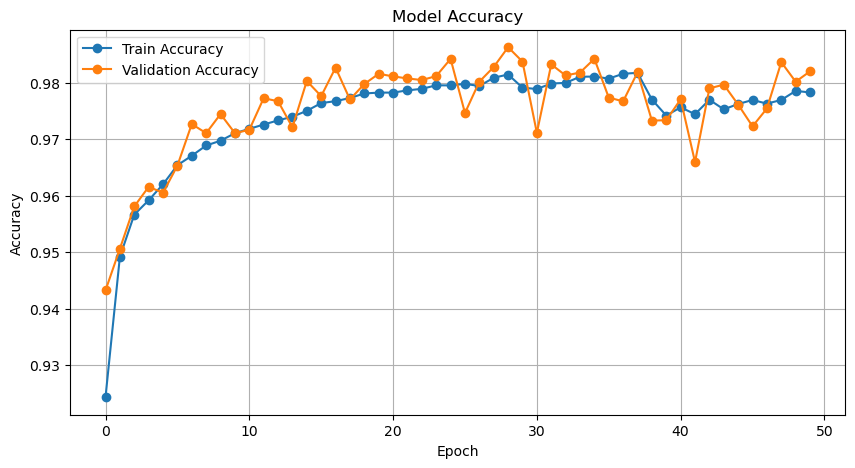

In [39]:
# Accuracy and loss plots
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("H23Q_Accuracy_multiclass.png")
plt.show()

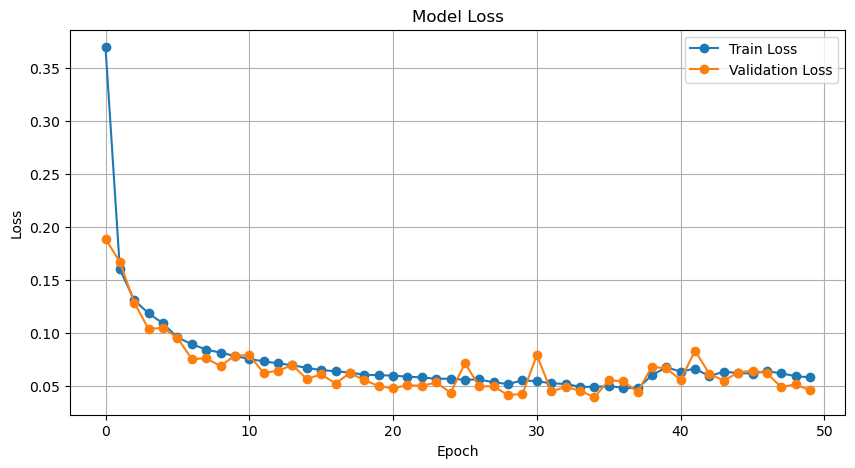

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("H23Q_loss_multiclass.png")
plt.show()

In [41]:
# Confusion matrix
y_pred = ensemble_model.predict([X_test_cnn, X_test_cnn, X_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

9400/9400 ━━━━━━━━━━━━━━━━━━━━ 143s 15ms/step


In [44]:
class_names = [
    'Normal','fuzzing', 'http-flood', 'http-loris', 'http-smuggle', 'http2-concurrent','http2-pause','quic-enc','quic-flood', 
      'quic-loris'
]

In [42]:
print(label_encoder.classes_)

[0 1 2 3 4 5 6 7 8 9]


In [43]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

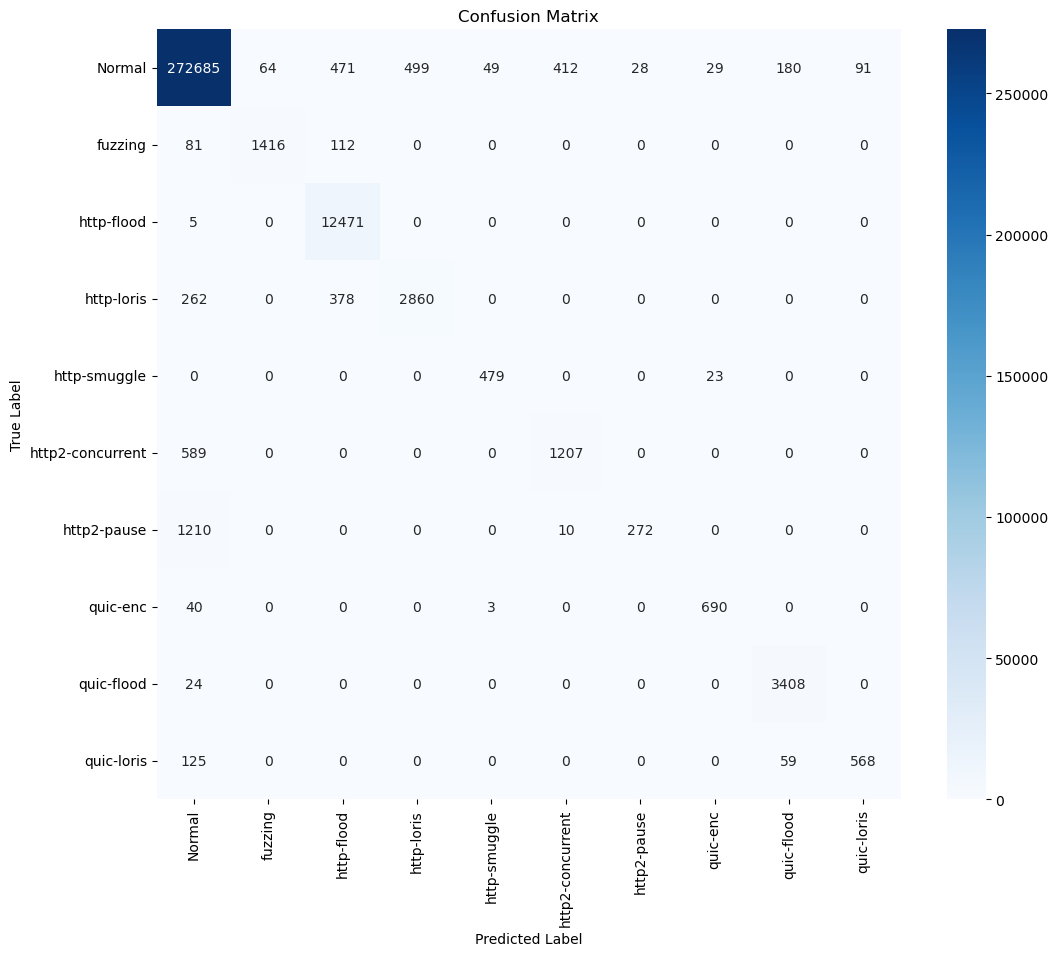

In [45]:
# Plot the confusion matrix with class names
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('H23Q_confusion_matrix_multiclass.png')
plt.show()

In [46]:

# Generate and print the classification report with the correct target names
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, zero_division=0)
print(report)

                  precision    recall  f1-score   support

          Normal       0.99      0.99      0.99    274508
         fuzzing       0.96      0.88      0.92      1609
      http-flood       0.93      1.00      0.96     12476
      http-loris       0.85      0.82      0.83      3500
    http-smuggle       0.90      0.95      0.93       502
http2-concurrent       0.74      0.67      0.70      1796
     http2-pause       0.91      0.18      0.30      1492
        quic-enc       0.93      0.94      0.94       733
      quic-flood       0.93      0.99      0.96      3432
      quic-loris       0.86      0.76      0.81       752

        accuracy                           0.98    300800
       macro avg       0.90      0.82      0.83    300800
    weighted avg       0.98      0.98      0.98    300800



In [72]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Assuming `y_true_classes` and `y_pred_classes` contain the true and predicted class labels respectively
# `class_names` contains the names of each class
n_classes = len(class_names)

# Binarize the true class labels for a "one-vs-rest" approach
y_true_binarized = label_binarize(y_true_classes, classes=range(n_classes))
y_pred_binarized = label_binarize(y_pred_classes, classes=range(n_classes))





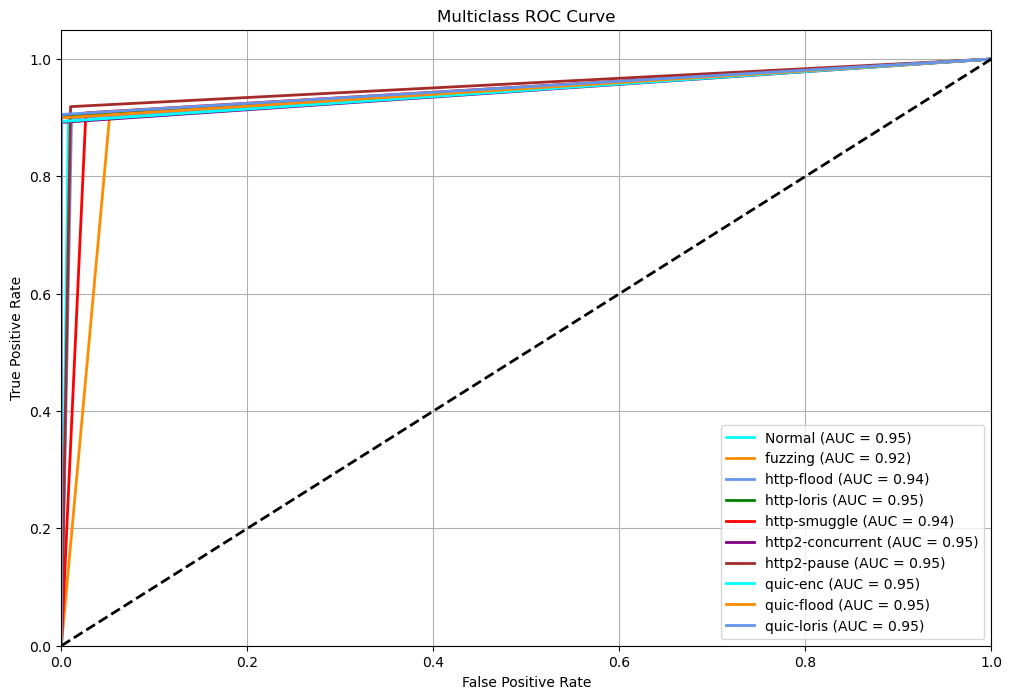

In [74]:
# ROC Curve
plt.figure(figsize=(12, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('H23Q_multiclass_ROC.png')
plt.show()


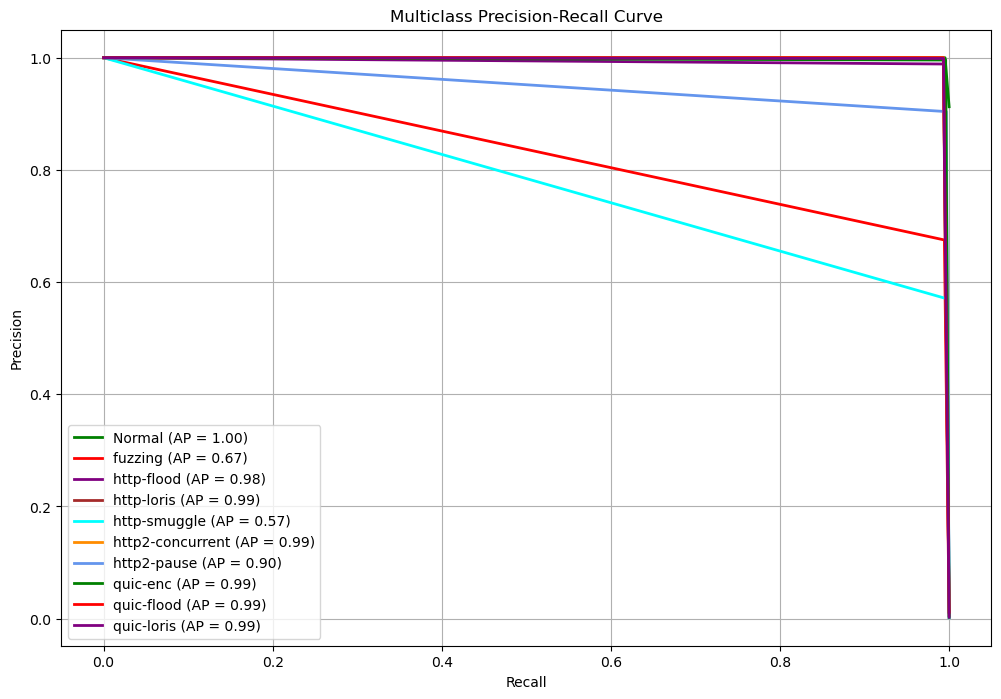

In [69]:
# Precision-Recall Curve
plt.figure(figsize=(12, 8))
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    average_precision = average_precision_score(y_true_binarized[:, i], y_pred_binarized[:, i])
    plt.plot(recall, precision, color=color, lw=2, label=f'{class_names[i]} (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.savefig('H23Q_multiclass_precision_recall.png')
plt.show()

In [47]:
# Correctly apply the attention mechanism to the combined features
attention_output, attention_weights = attention_mechanism(combined)

# Then, create the final output layer
output = Dense(num_classes, activation='softmax', name='output_layer')(attention_output)

# Define the complete ensemble model
ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, fnn_model.input], outputs=output)

In [48]:
# Extract attention weights from the model
attention_model = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.get_layer('attention_weights').output)
attention_weights_test = attention_model.predict([X_test_cnn, X_test_cnn, X_test])

9400/9400 ━━━━━━━━━━━━━━━━━━━━ 85s 9ms/step


In [49]:
avg_attention_weights = np.mean(attention_weights_test, axis=0)

In [51]:
avg_attention_weights = avg_attention_weights[:len(selected_features)]
selected_features = selected_features[:len(avg_attention_weights)]

In [54]:
# Create a DataFrame for visualization with actual feature names
attention_df = pd.DataFrame({
    'Feature': selected_feature_names,  # Use the actual feature names
    'Attention Weight': avg_attention_weights
})

# Print the DataFrame to inspect
print(attention_df)

                       Feature  Attention Weight
0                   frame.time          0.038286
1             frame.time_epoch          0.034203
2             frame.time_delta          0.033412
3   frame.time_delta_displayed          0.030658
4          frame.time_relative          0.037990
5                    frame.len          0.036313
6                   ip.hdr_len          0.036523
7              ip.dsfield.dscp          0.029077
8               ip.dsfield.ecn          0.033833
9                  ip.flags.df          0.030536
10                 ip.flags.mf          0.033543
11                      ip.ttl          0.033964
12                      ip.src          0.033250
13                      ip.dst          0.036400


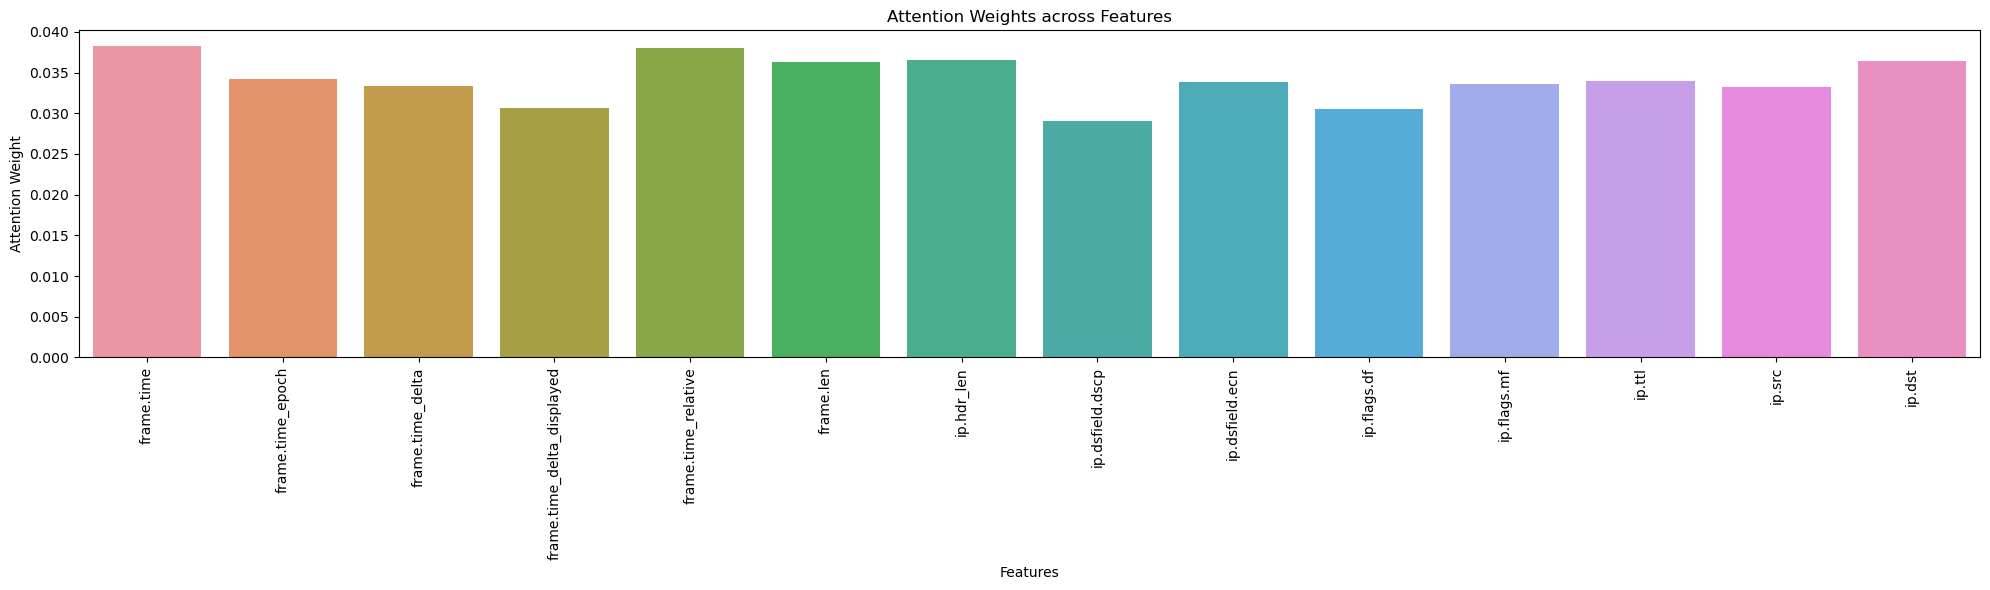

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the attention weights
plt.figure(figsize=(20, 6))
sns.barplot(x='Feature', y='Attention Weight', data=attention_df)
plt.title('Attention Weights across Features')
plt.xlabel('Features')
plt.ylabel('Attention Weight')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('attention_weights_plot.png')  # Save the plot as an image file
plt.show() 

9400/9400 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step


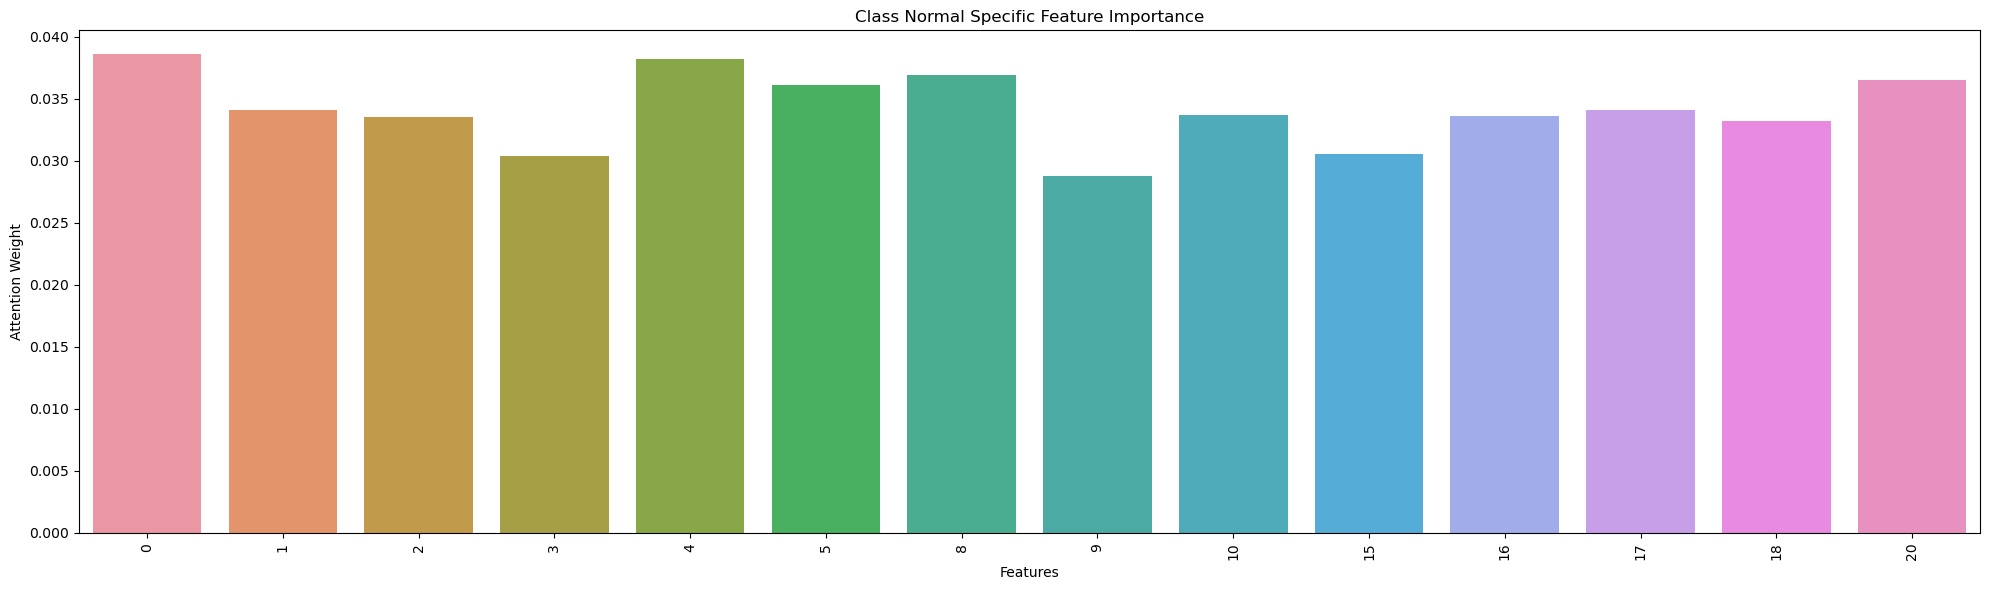

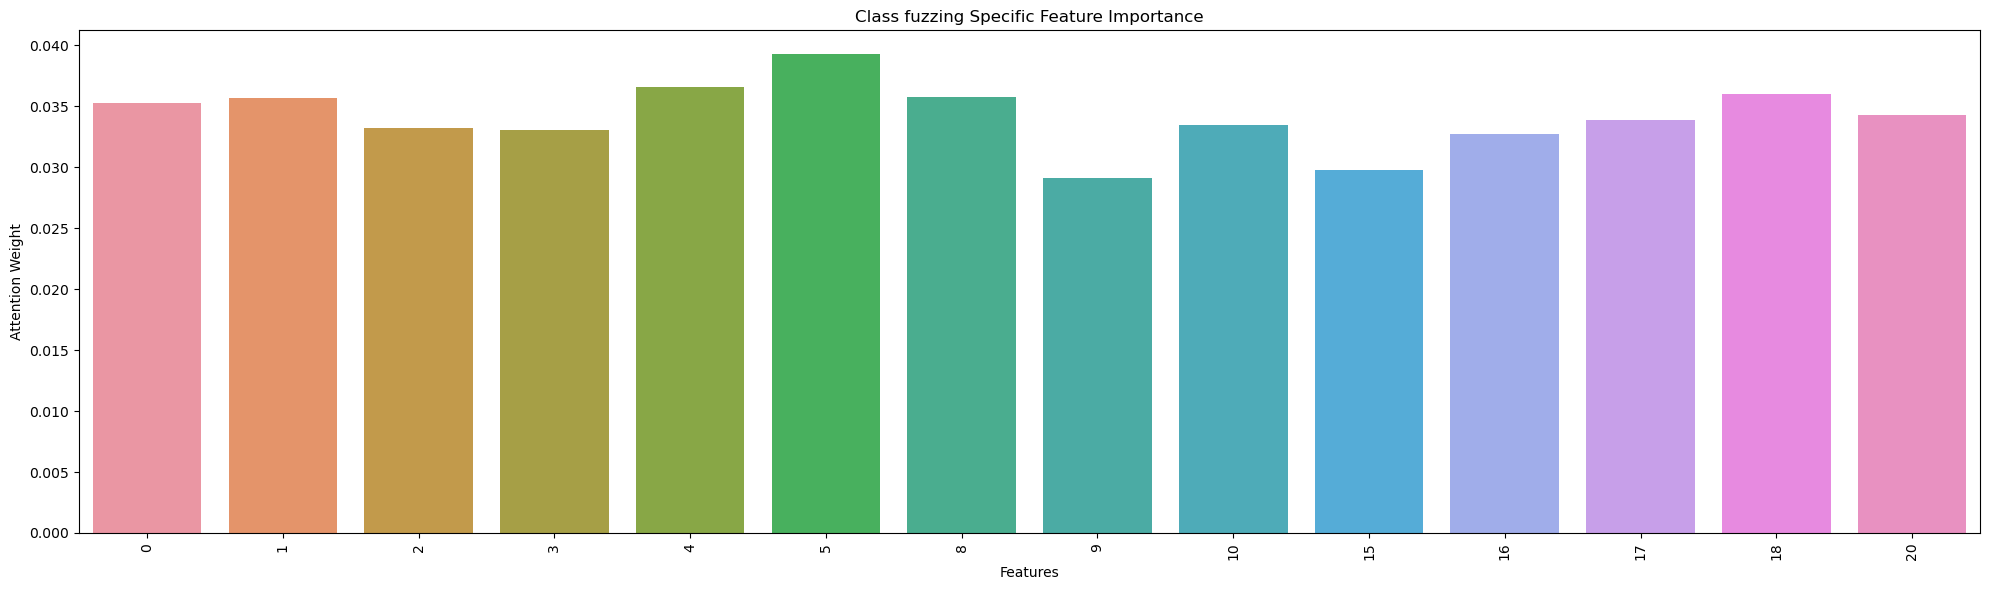

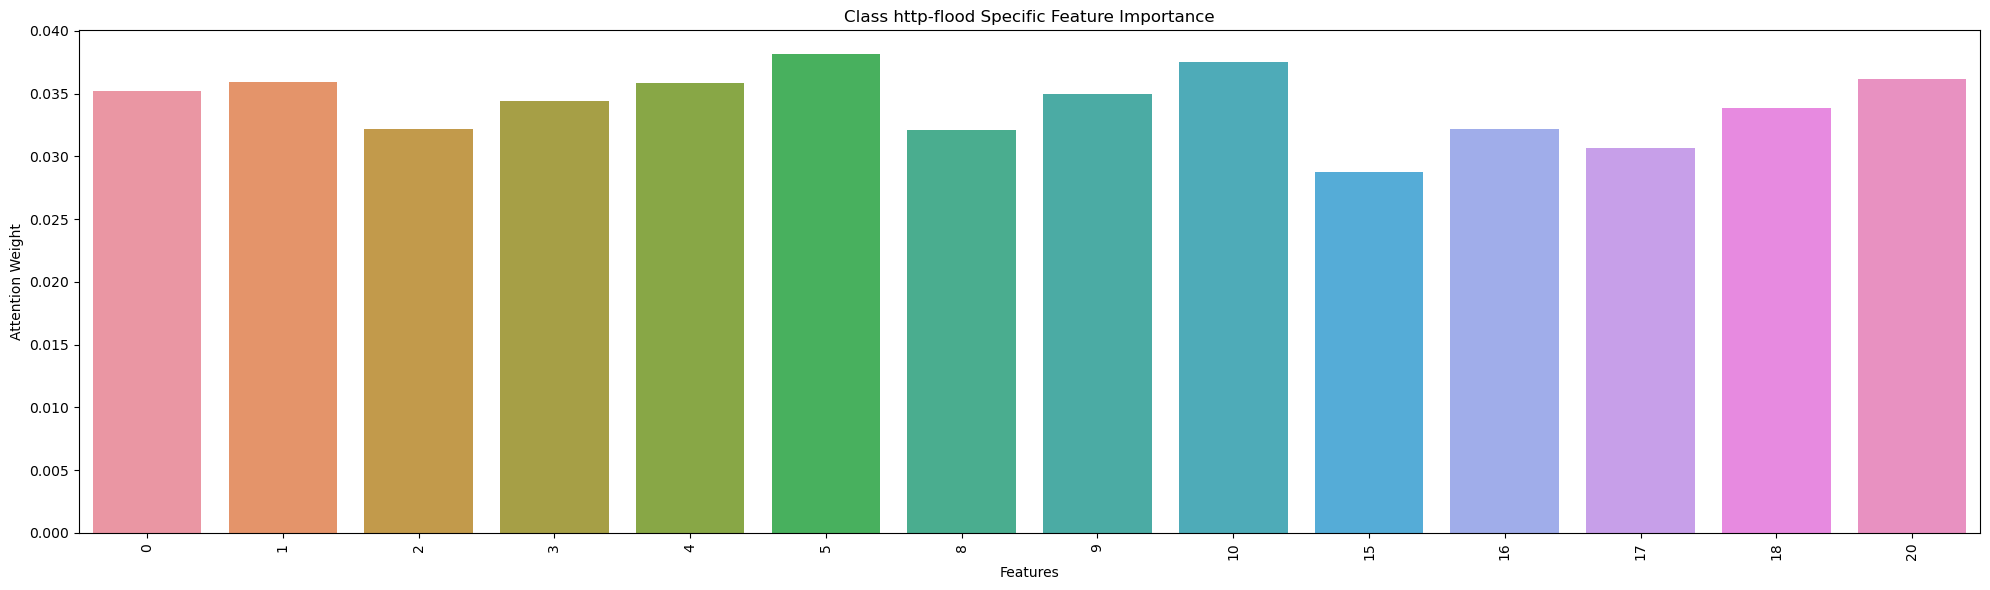

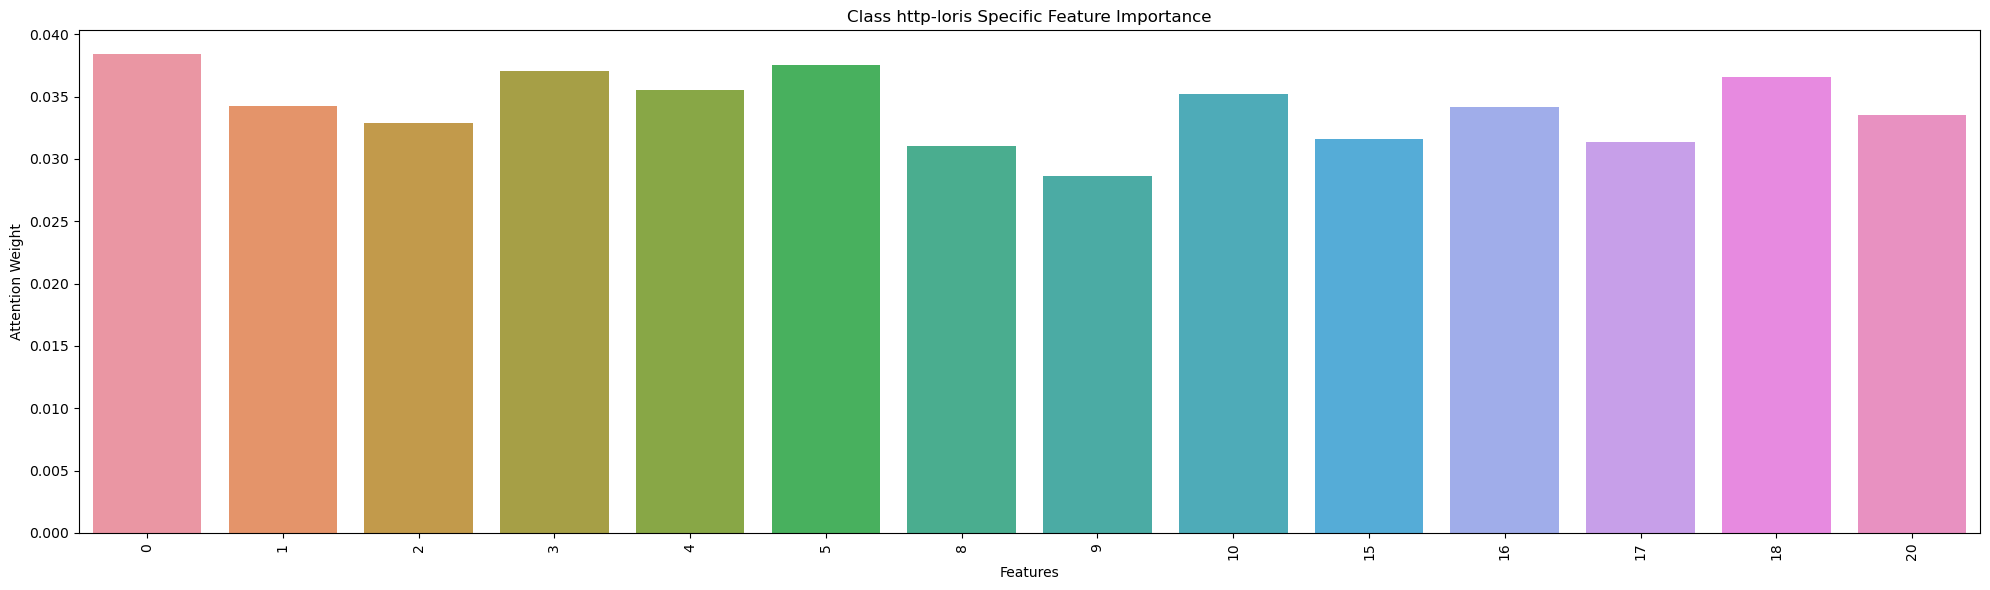

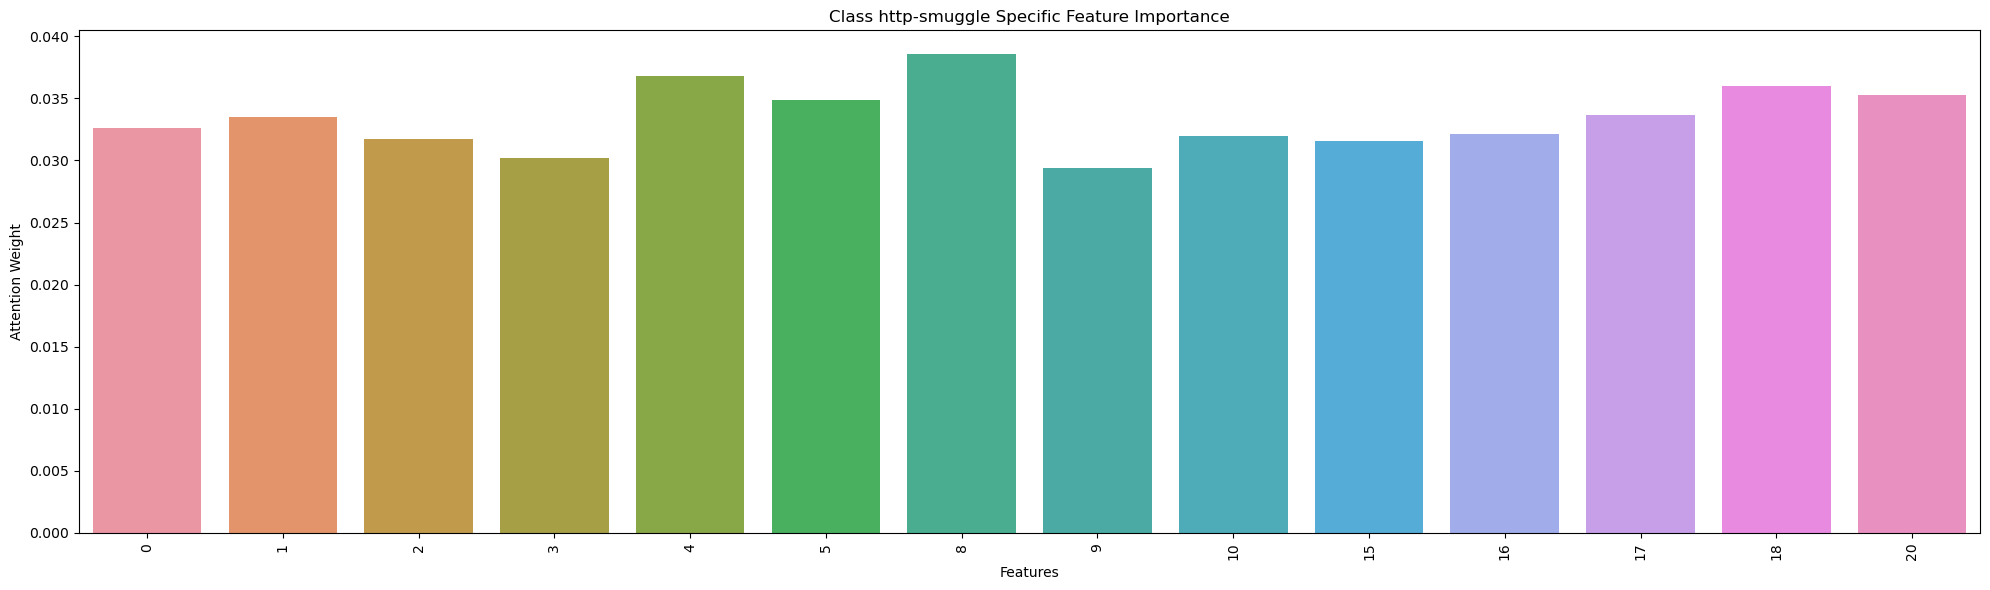

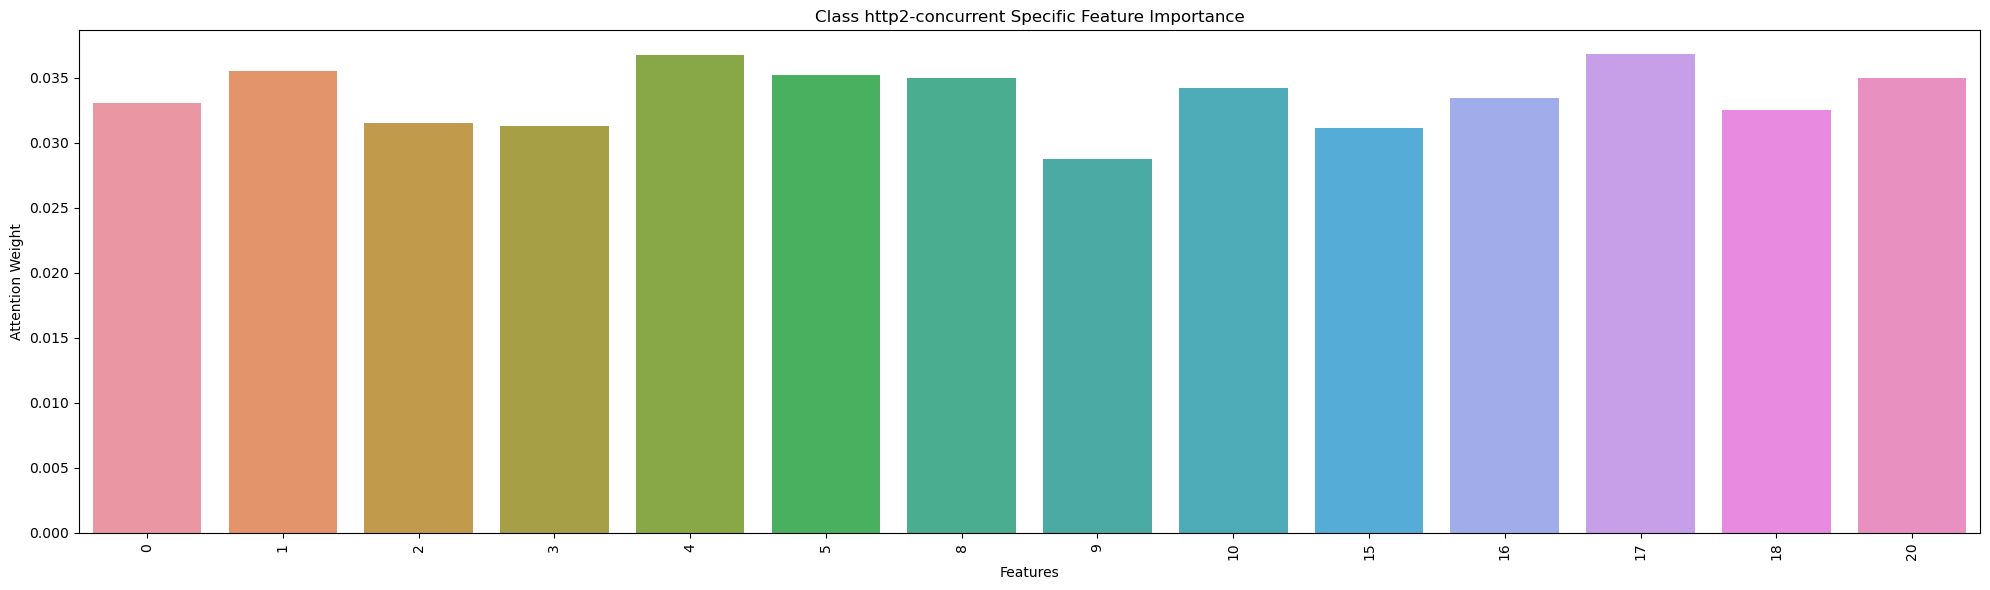

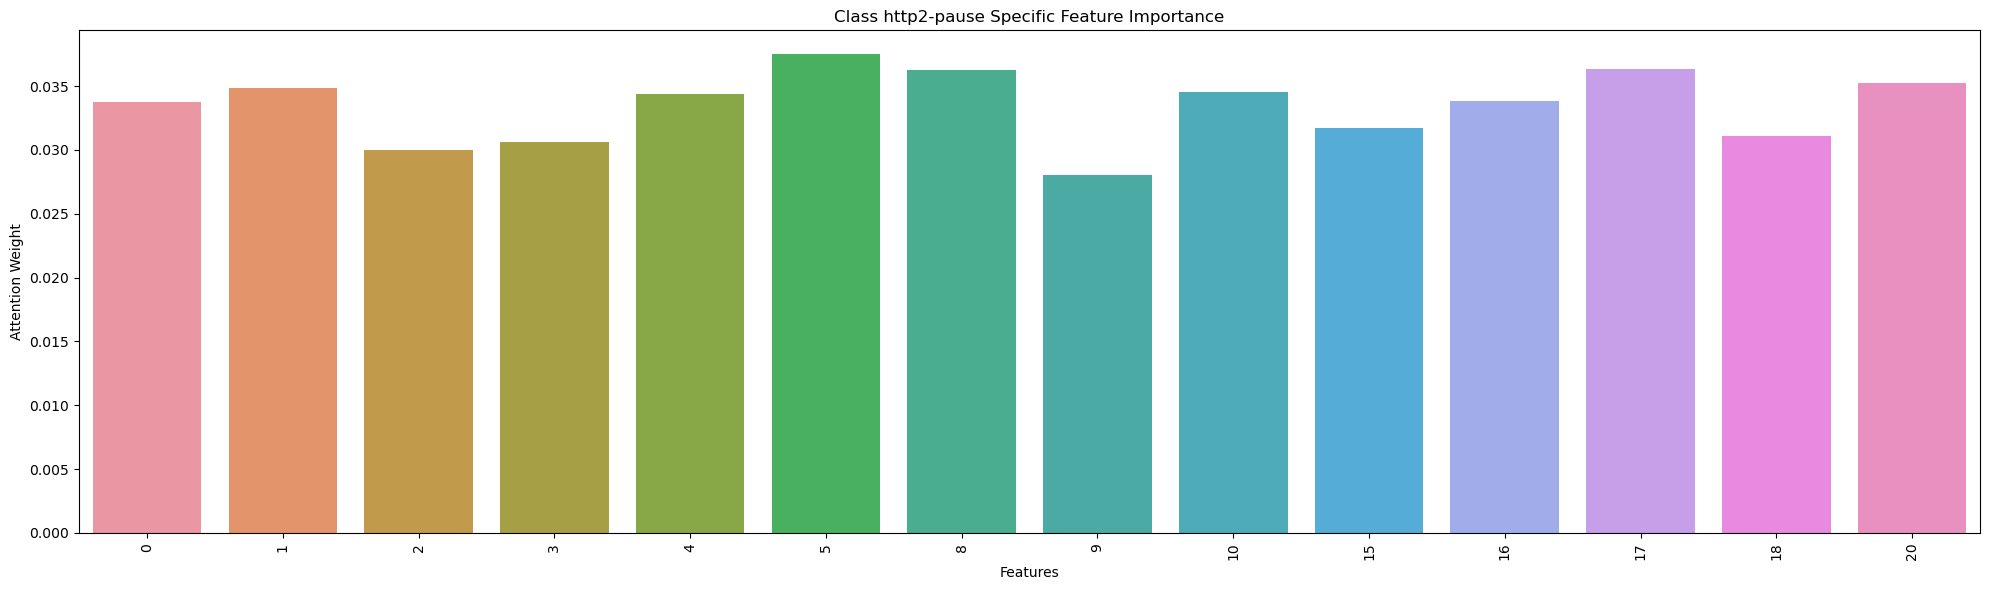

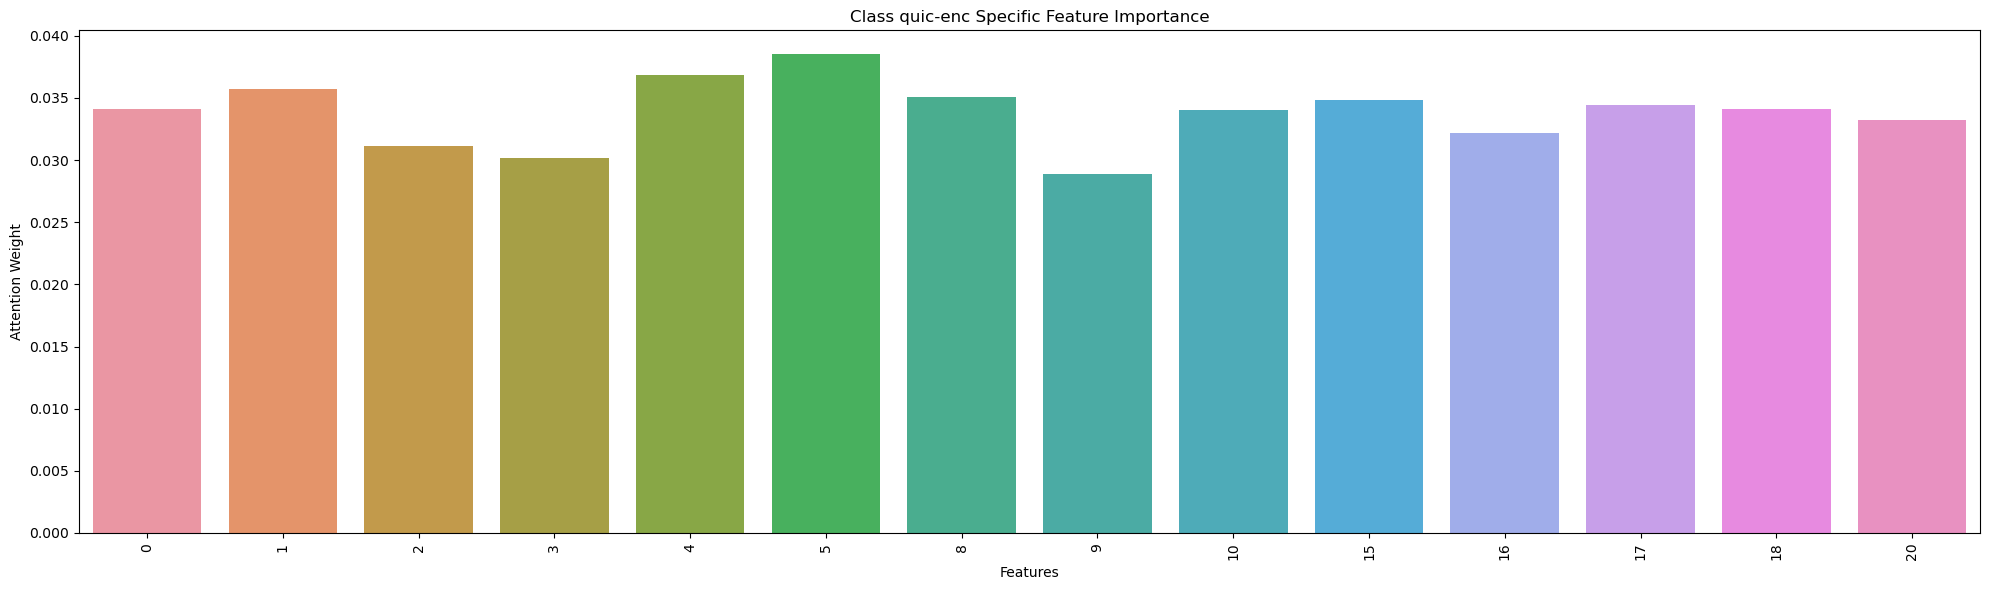

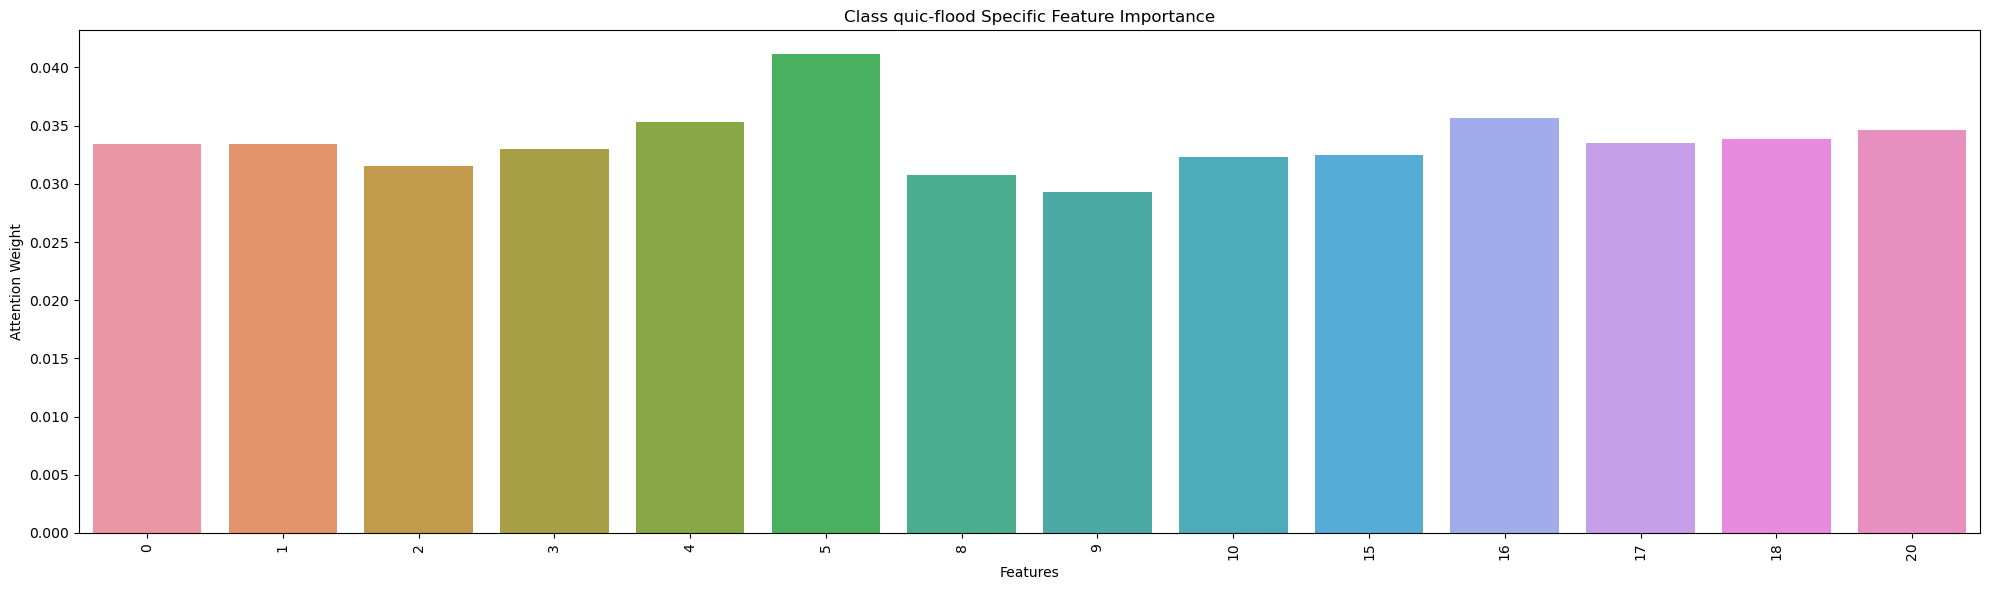

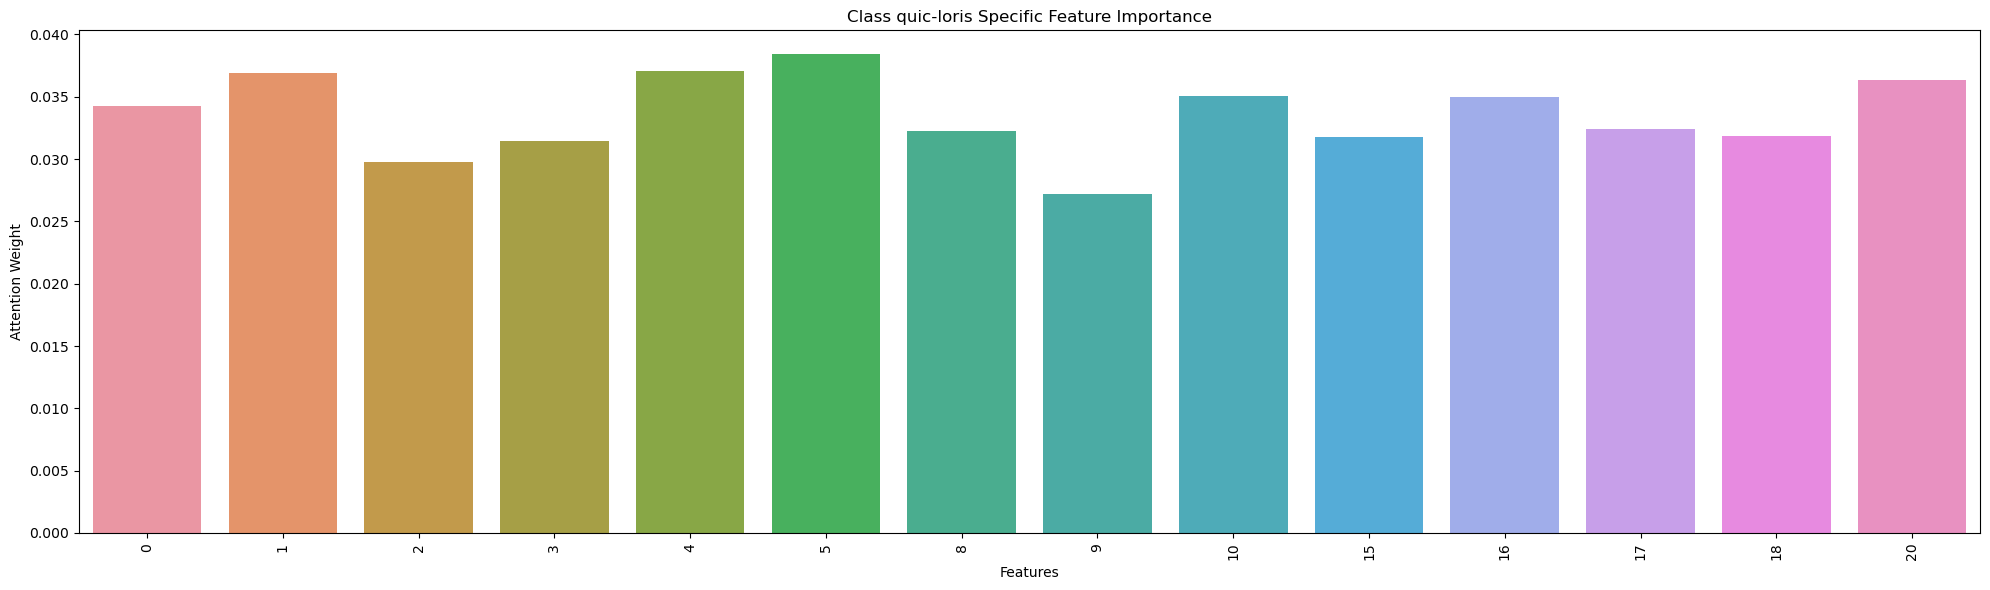

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Truncate the attention weights if they have more features than selected
attention_weights_test = attention_weights_test[:, :len(selected_features)]

# Get the predicted classes
y_pred_classes = np.argmax(ensemble_model.predict([X_test_cnn, X_test_cnn, X_test]), axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Initialize an array to store class-specific attention weights
num_classes = y_test.shape[1]
class_specific_weights = np.zeros((num_classes, len(selected_features)))

# Compute average attention weights per class
for class_idx in range(num_classes):
    class_indices = np.where(y_true_classes == class_idx)[0]
    if len(class_indices) > 0:
        class_specific_weights[class_idx] = np.mean(attention_weights_test[class_indices], axis=0)
    else:
        print(f"No samples found for class {class_idx}.")


# Plot the attention weights for each class
for class_idx in range(num_classes):
    plt.figure(figsize=(20, 6))
    sns.barplot(x=selected_features, y=class_specific_weights[class_idx])
    plt.title(f'Class {class_names[class_idx]} Specific Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Attention Weight')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f'class_{class_names[class_idx]}_attention_weights.png')
    plt.show()


9400/9400 ━━━━━━━━━━━━━━━━━━━━ 100s 11ms/step


C:\Users\ramya\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


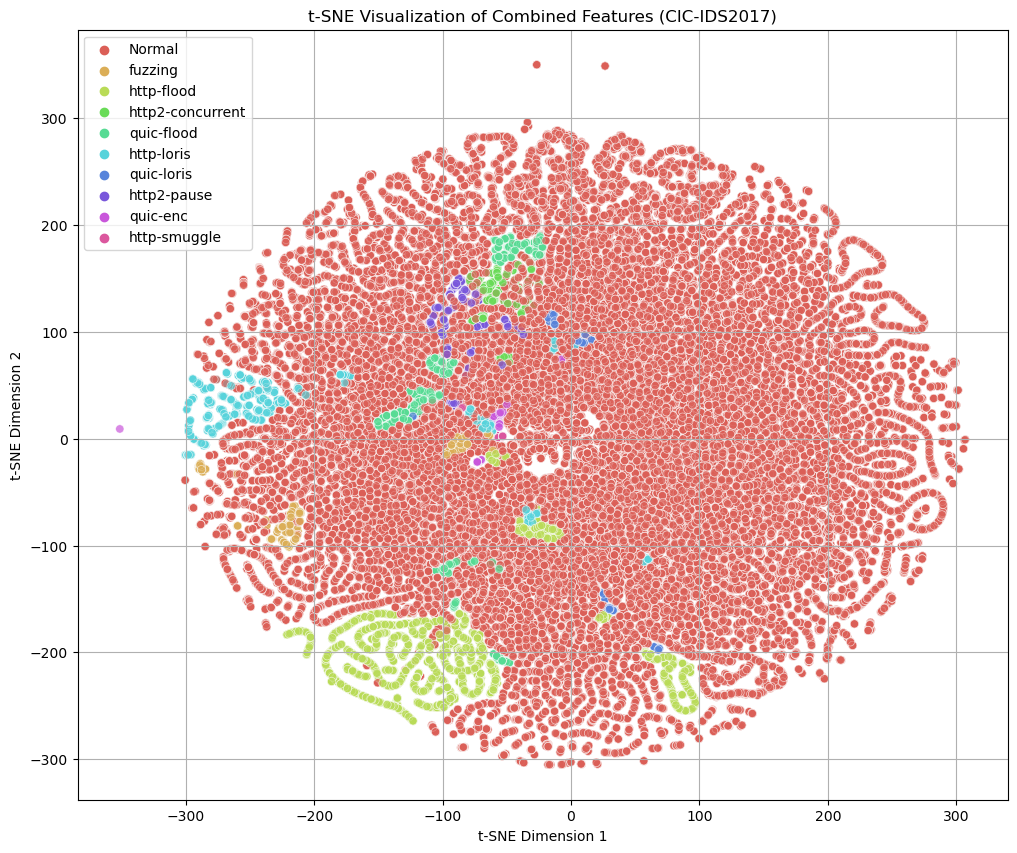

In [58]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Extract combined features from the ensemble model before the attention mechanism
# Assuming 'combined_features' is the last layer before attention in your model
feature_extractor = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.get_layer('combined_features').output)
combined_features_test = feature_extractor.predict([X_test_cnn, X_test_cnn, X_test])

# Perform t-SNE to reduce the combined features to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(combined_features_test)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame({
    't-SNE1': tsne_results[:, 0],
    't-SNE2': tsne_results[:, 1],
    'Label': y_true_classes  # Use the true class labels from test data
})
# Create a new column in tsne_df for the attack names
tsne_df['Attack_Name'] = tsne_df['Label'].map(lambda x: class_names[x])

# Now plot using the attack names instead of class labels
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='t-SNE1', y='t-SNE2',
    hue='Attack_Name',  # Color by attack names
    palette=sns.color_palette('hls', len(class_names)),  # Use distinct colors for each attack
    data=tsne_df,
    legend='full',
    alpha=0.7
)
plt.title('t-SNE Visualization of Combined Features (CIC-IDS2017)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('CIC_IDS2017_t-SNE_multiclass_attack_names.png')
plt.show()

In [75]:
# Save the model
import pickle
ensemble_model.save('H23Q_ensemble_model.keras')


# Save the training history
with open('H23Q_training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)